In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import celerite as celery
import exoplanet as xo
np.random.seed(42)
%matplotlib inline

data_dir = '/Users/mbedell/python/pmodes/experiments/data/'

In [2]:
import pymc3 as pm
import theano.tensor as tt
from exoplanet.gp import terms, GP

In [3]:
xlim_data = np.array([10.2, 10.8]) * 86400 # for selecting all data
xlim_plot = [890000, 895000] # for zoomed-in plots

#### Try fitting a GP to a short timeseries of single-mode RV oscillations:

In [4]:
d = np.genfromtxt(data_dir+'sim_oneyear_onemode.csv', names=True, dtype=None, delimiter=',')
ts_onemode = np.copy(d['ts'])
rvs_onemode = np.copy(d['rvs'])
xs_onemode = np.copy(d['xs'])

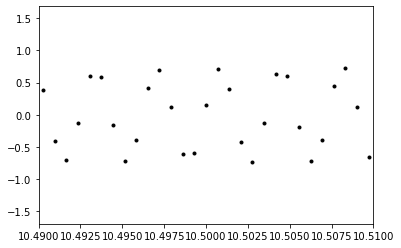

In [5]:
plt.plot(ts_onemode/86400., rvs_onemode, 'k.')
plt.xlim([10.49,10.51]);

In [6]:
inds = (ts_onemode > 10.49 * 86400) & (ts_onemode < 10.51 * 86400)
t = ts_onemode[inds]
y = rvs_onemode[inds]
yerr = np.zeros_like(y) + 0.01 # 1 cm/s homogeneous error - made up!
t_grid = np.linspace(t[0], t[-1], 1000)
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs_onemode)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
132it [00:00, 272.16it/s, logp=7.609279e+01] 
message: Desired error not necessarily achieved due to precision loss.
logp: 32.259569351810896 -> 76.09279191086408


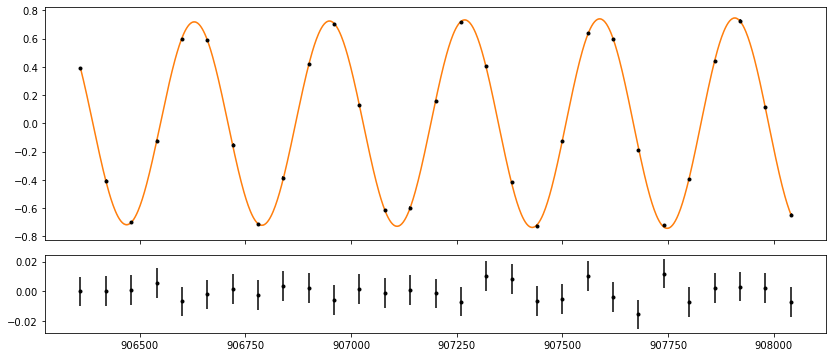

In [7]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})
ax1.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")

# Plot the prediction and the 1-sigma uncertainty
art = ax1.fill_between(t_grid, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_grid, mu, color="C1", label="prediction")

ax2.errorbar(t, y - y_pred, yerr=yerr, fmt=".k", capsize=0, label="resids");

In [8]:
map_soln

{'logS0': array(-7.61159922),
 'logw0': array(-3.92939734),
 'logQ': array(9.86272682)}

This isn't quite what we expected - our calculation from `01-simulating-data.ipynb` was:
```
log_S0: -9.33721059
log_Q: 8.13423472
log_omega0: -3.92565541
```
BUT we do have an amplitudes issue when actually generating RVs from a GP with the above kernel and comparing to the RVs that we're using here, so maybe our expected logS0 is incorrect anyway.

#### Try with multi-mode RVs:

In [9]:
d = np.genfromtxt(data_dir+'sim_oneyear.csv', names=True, dtype=None, delimiter=',')
ts_multimode = np.copy(d['ts'])
rvs_multimode = np.copy(d['rvs'])
xs_multimode = np.copy(d['xs'])

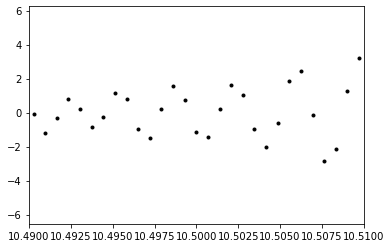

In [10]:
plt.plot(ts_multimode/86400., rvs_multimode, 'k.')
plt.xlim([10.49,10.51]);

In [11]:
inds = (ts_multimode > 10.49 * 86400) & (ts_multimode < 10.51 * 86400)
t = ts_multimode[inds]
y = rvs_multimode[inds]
yerr = np.zeros_like(y) + 0.01 # 1 cm/s homogeneous error - made up!
t_grid = np.linspace(t[0], t[-1], 1000)
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs_onemode)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
21it [00:00, 860.59it/s, logp=-1.431953e+01] 
message: Optimization terminated successfully.
logp: -153.67169156782754 -> -14.319532140086299


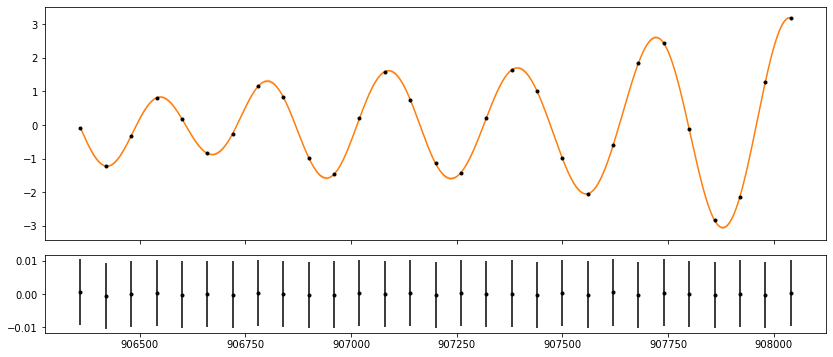

In [12]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})
ax1.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")

# Plot the prediction and the 1-sigma uncertainty
sd = np.sqrt(var)
art = ax1.fill_between(t_grid, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_grid, mu, color="C1", label="prediction")

ax2.errorbar(t, y - y_pred, yerr=yerr, fmt=".k", capsize=0, label="resids");

In [13]:
map_soln

{'logS0': array(0.68131953),
 'logw0': array(-3.89281373),
 'logQ': array(5.32584365)}

This is also an excellent fit, even though we only used one mode. Maybe a single DDHO is a good approximation over short timescales - let's try a longer stretch.

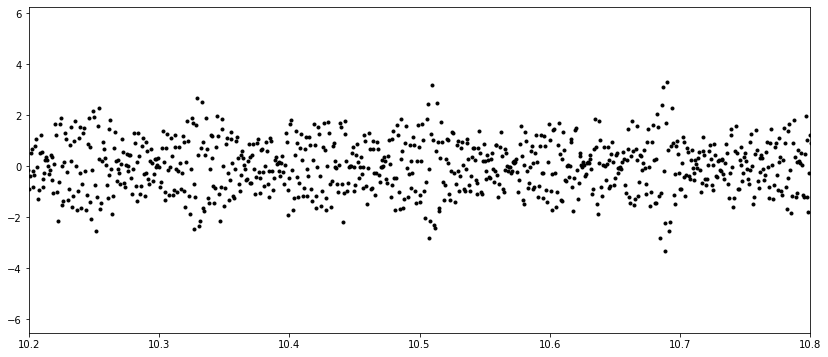

In [14]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(ts_multimode/86400., rvs_multimode, 'k.')
ax.set_xlim([10.2,10.8]);

In [15]:
inds = (ts_multimode > xlim_data[0]) & (ts_multimode < xlim_data[1])
t_all = ts_multimode[inds]
y_all = rvs_multimode[inds]
yerr_all = np.zeros_like(y) + 0.01 # 1 cm/s homogeneous error - made up!
t_grid = np.linspace(xlim_data[0], xlim_data[1], 1000)

In [ ]:
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs_onemode)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t_all, yerr_all ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y_all))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t_all), map_soln)

In [ ]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})
ax1.errorbar(t_all, y_all, yerr=yerr_all, fmt=".k", capsize=0, label="data")

# Plot the prediction and the 1-sigma uncertainty
art = ax1.fill_between(t_grid, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_grid, mu, color="C1", label="prediction")

ax2.errorbar(t_all, y_all - y_pred, yerr=yerr_all, fmt=".k", capsize=0, label="resids", alpha=0.3)

ax2.set_xlabel('Time (s)', fontsize=14)
ax1.set_ylabel(r'RV (m s$^{-1}$)', fontsize=14)
ax2.set_ylabel('Resids', fontsize=12)

ax2.set_xlim(xlim_data)

ax1.set_title('using all data', fontsize=12);

#### multi-mode RVs, sparser data:

In [ ]:
inds = np.random.choice(np.arange(len(t_all)), size=200, replace=False)
inds.sort()
t = t_all[inds]
y = y_all[inds]
yerr = np.zeros_like(y) + 0.01 # 1 cm/s homogeneous error - made up!
t_grid = np.linspace(t[0], t[-1], 10000)

In [ ]:
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs_onemode)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)
    y_pred_all = xo.eval_in_model(gp.predict(t_all), map_soln)

In [ ]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})
                              
art = ax1.fill_between(t_grid, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_grid, mu, color="C1", label="prediction")

ax1.plot(ts_multimode, rvs_multimode, ".k")
ax1.errorbar(t, y, yerr=yerr, fmt=".r", capsize=0, label="data")

ax2.errorbar(t_all, y_all - y_pred_all, yerr=yerr_all, fmt=".k", capsize=0, label="resids", alpha=0.3)
ax2.errorbar(t, y - y_pred, yerr=yerr, fmt=".r", capsize=0, label="resids", alpha=0.3)

inds = (t_all > xlim_plot[0]) & (t_all < xlim_plot[1])
chisq = np.sum(((y_all - y_pred_all)/yerr_all)[inds])**2
ax2.text(xlim_plot[0] + 100, 0.6, r'$\chi^2$ = {0:.2f}'.format(chisq), fontsize=12)
ax2.set_xlabel('Time (s)', fontsize=14)
ax1.set_ylabel(r'RV (m s$^{-1}$)', fontsize=14)
ax2.set_ylabel('Resids', fontsize=12)

ax1.set_xlim(xlim_plot);

OK good, so this doesn't work perfectly well for predicting! Let's test whether the same predictions get any better if the GP kernel we use has the entire comb of modes.

In [ ]:
a_max = 0.55 # amplitude of central mode in m/s
nu_max = 3.1e-3 # peak frequency in Hz
c_env = 0.331e-3 # envelope width in Hz
delta_nu = 0.00013 # Hz
gamma = 1. / (2 * 24. * 60. * 60.) # s^-1 ; 2-day damping timescale
dt = 50. # seconds - approximate Nyquist sampling

freq_grid = np.arange(nu_max - 0.001, nu_max + 0.001, delta_nu) # magic numbers
omega_grid = 2.*np.pi*freq_grid # angular frequencies
amp_grid = a_max**2 * np.exp(-(freq_grid-nu_max)**2/(2.*c_env**2)) # amplitudes in m/s
driving_amp_grid = np.sqrt(amp_grid * gamma * dt)
log_S0_grid = [np.log(d**2 / (dt * o)) for o,d in zip(omega_grid,driving_amp_grid)]

#print("log_S0_grid: {0}".format(log_S0_grid))
#print("log(omega_grid): {0}".format(np.log(omega_grid)))
#print("log(Q_grid): {0}".format(np.log(omega_grid/gamma)))

##### note: the following code is quite slow. maybe should do this hierarchically.

Try this as a hierarchical model with the following:

hyperparameters $\nu_{max}$, $\Delta\nu$, $a_{max}$, $c_{env}$, $\gamma$

**Note:** Not sure about use of gamma; also, might be missing some $2\pi$ factors due to $\nu$/$\omega$ inconsistencies.

In [ ]:
n_modes = 15 # must be odd (so that comb is symmetric around nu_max)

with pm.Model() as model:
    # Set up the kernel and GP
    kernel = None
    logS0_vars = np.array([])
    logw0_vars = []
    logQ_vars = []
    
    # Hyperparameters
    nu_max = pm.Normal("nu_max", mu=3.e-3, sd=1.0)
    delta_nu = pm.Normal("delta_nu", mu=1.e-4, sd=0.01)
    c_env = pm.Normal("c_env", mu=0.3e-3, sd=1.0)
    a_max = pm.Normal("a_max", mu=0.5, sd=10.0)
    gamma = pm.Normal("gamma", mu=1./(2 * 24. * 60. * 60.), sd=10.)
    
    nu_grid = (np.arange(n_modes) - n_modes/2) * delta_nu + nu_max
    for i,n in enumerate(nu_grid):
        amp = a_max**2 * np.exp(-(n-nu_max)**2/(2.*c_env**2))
        lSv = pm.log(amp)
        lQv = pm.log(n/gamma)
        lwv = pm.log(n)
        # add variables:
        logS0_vars = np.append(logS0_vars, lSv)
        logw0_vars = np.append(logw0_vars, lwv)
        logQ_vars = np.append(logQ_vars, lQv)
        # add kernel:
        if kernel is None:
            kernel = terms.SHOTerm(log_S0=lS, log_w0=lwv, log_Q=lQv)
        else:
            kernel += terms.SHOTerm(log_S0=lS, log_w0=lwv, log_Q=lQv)

    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)
    y_pred_all = xo.eval_in_model(gp.predict(t_all), map_soln)

### Longer-integration observations

Now that we're satisfied the GP works in general, let's test how it performs for observations that are integrated over longer times.

In [ ]:
from scipy.interpolate import interp1d

def simulate_exposure(ts, rvs, start_time, exp_time):
    pad = 100. # seconds - ARBITRARY
    smaller_inds = (ts > (start_time - pad)) & (ts < (start_time + exp_time + pad))    
    interp = interp1d(ts[smaller_inds], rvs[smaller_inds], kind='cubic')
    tiny = 0.1 # 100 ms
    fine_ts = np.arange(start_time, start_time+exp_time, tiny) # fine grid
    fine_rvs = interp(fine_ts)
    return np.sum(fine_rvs)/len(fine_rvs) # ASSUMES EVEN WEIGHTING - technically incorrect for last point

In [ ]:
inds = (ts_multimode > 10.2 * 86400) & (ts_multimode < 10.8 * 86400)
exp_time = 2. * 60. #seconds
start_ts = ts_multimode[inds]
mid_rvs = np.array([simulate_exposure(ts_multimode, rvs_multimode, tt, exp_time) for tt in start_ts])
mid_ts = start_ts + exp_time/2.

In [ ]:
t_all = mid_ts
y_all = mid_rvs
yerr_all = np.zeros_like(y_all) + 0.01 # 1 cm/s homogeneous error - made up!

inds = np.random.choice(np.arange(len(t_all)), size=200, replace=False)
inds.sort()
t = mid_ts[inds]
y = mid_rvs[inds]
yerr = yerr_all[inds]
t_grid = np.linspace(t[0], t[-1], 10000)

#### integrated exposures modeled with single-SHO kernel non-integrated GP:

In [ ]:
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs_onemode)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)
    y_pred_all = xo.eval_in_model(gp.predict(t_all), map_soln)

In [ ]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})
                              
art = ax1.fill_between(t_grid, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_grid, mu, color="C1", label="prediction")

ax1.errorbar(t_all, y_all, yerr=yerr_all, fmt=".k", capsize=0, label='validation data')
ax1.errorbar(t, y, yerr=yerr, fmt=".r", capsize=0, label="training data")
ax1.legend(fontsize=12)

ax2.errorbar(t_all, y_all - y_pred_all, yerr=yerr_all, fmt=".k", capsize=0, alpha=0.3)
ax2.errorbar(t, y - y_pred, yerr=yerr, fmt=".r", capsize=0, alpha=0.3)

inds = (t_all > xlim_plot[0]) & (t_all < xlim_plot[0])
chisq = np.sum(((y_all - y_pred_all)/yerr_all)[inds])**2
ax2.text(xlim_plot + 100, 0.6, r'$\chi^2$ = {0:.2f}'.format(chisq), fontsize=12)
ax2.set_xlabel('Time (s)', fontsize=14)
ax1.set_ylabel(r'RV (m s$^{-1}$)', fontsize=14)
ax2.set_ylabel('Resids', fontsize=12)

ax1.set_xlim(xlim_plot);

In [ ]:
print(map_soln)

#### integrated exposures modeled with single-SHO kernel integrated GP:

In [ ]:
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs_onemode)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    kernel_int = terms.IntegratedTerm(kernel, exp_time)
    gp = GP(kernel_int, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t), map_soln)
    y_pred_all = xo.eval_in_model(gp.predict(t_all), map_soln)

In [ ]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})
                              
art = ax1.fill_between(t_grid, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_grid, mu, color="C1", label="prediction")

ax1.errorbar(t_all, y_all, yerr=yerr_all, fmt=".k", capsize=0, label='validation data')
ax1.errorbar(t, y, yerr=yerr, fmt=".r", capsize=0, label="training data")
ax1.legend(fontsize=12)

ax2.errorbar(t_all, y_all - y_pred_all, yerr=yerr_all, fmt=".k", capsize=0, label="resids", alpha=0.3)
ax2.errorbar(t, y - y_pred, yerr=yerr, fmt=".r", capsize=0, label="resids", alpha=0.3)

inds = (t_all > xlim_plot[0]) & (t_all < xlim_plot[1])
chisq = np.sum(((y_all - y_pred_all)/yerr_all)[inds])**2
ax2.text(xlim_plot[0] + 100, 0.6, r'$\chi^2$ = {0:.2f}'.format(chisq), fontsize=12)
ax2.set_xlabel('Time (s)', fontsize=14)
ax1.set_ylabel(r'RV (m s$^{-1}$)', fontsize=14)
ax2.set_ylabel('Resids', fontsize=12)

ax1.set_xlim(xlim_plot);

In [ ]:
print(map_soln)